## SpitsGidsPredictor

This is a notebook that uses some retrospective data and evaluate if machine learning techniques could predict the occupancy on a train, given the data from iRails API.

<script>console.log('test')</script>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
from dateutil.parser import parse
import re
import matplotlib.pyplot as plt
import matplotlib
from xgboost import plot_importance
import requests
from sklearn.cross_validation import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import time
import datetime
from datetime import date
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
import numpy as np
import pytz
from sklearn.tree import DecisionTreeClassifier
import xml.etree.ElementTree as ET
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### TODO's:

    * Group the logs according to their connection (at this moment, a log corresponds to a user rating,
      which can lead to multiple users sending different occupancy ratings on the same train) (use pandas pivot table)
    * Use event data from uitdatabank or eventful
    * Re-run hyper-parameter optimization
    * BorutaPy Feature Selection
    * !!!! GET MORE DATA !!!!
    * Plot learning curves for every addition of features
    * Try SVM, Multi-Class NN

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### 1. Reading the occupancy (JSON) log file

In [11]:
# {"querytype":"occupancy","querytime":"2016-07-27T20:05:51+02:00",
# "post":{"connection":"http://irail.be/connections/8813003/20160727/IC1518",
# "from":"http://irail.be/stations/NMBS/008813003",
# "date":"Sun Jan 18 1970 01:14:03 GMT+0100 (CET)",
# "vehicle":"http://irail.be/vehicle/IC1518",
# "occupancy":"http://api.irail.be/terms/high"},
# "user_agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 
# (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36"}
_columns = ['querytime', 'seconds_since_midnight', 'hour', 'weekday', 'month', 'connection', 
            'from', 'from_string', 'from_lat', 'from_lng', 'morning_jam', 'evening_jam',
            'to', 'to_string', 'to_lat', 'to_lng', 'vehicle', 'vehicle_type', 'occupancy',
            'year', 'day', 'quarter']

stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'latitude', 'longitude']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
week_day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def parse_file(path):
    parsed_logs = []
    faulty_logs = 0
    time_zones = []
    with open(path) as data_file:  
        for line in data_file:
            occ_logline = json.loads(line)
            morning_commute = 0
            evening_commute = 0
            commute_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            # Do a check if the querytype is occupancy
            if occ_logline['querytype'] == 'occupancy' and 'error' not in occ_logline \
            and 'querytime' in occ_logline:

                    try:
                        query_time = occ_logline['querytime']
                        try:
                            parsed_query_time = parse(query_time)
                            week_day = week_day_mapping[parsed_query_time.weekday()]
                            weekday_nr = parsed_query_time.weekday()
                            midnight = parsed_query_time.replace(hour=0, minute=0, second=0, microsecond=0)
                            seconds_since_midnight = (parsed_query_time - midnight).seconds
                            day = parsed_query_time.day
                            year = parsed_query_time.year
                            month = parsed_query_time.month
                            hour = parsed_query_time.hour
                            quarter = int(parsed_query_time.minute/15)
                            timezone_offset = parsed_query_time.tzinfo._offset
                            time_zones.append(timezone_offset)
                            hours_offset, remainder = divmod(timezone_offset.seconds, 3600)
                            # De ochtendspits valt doorgaans in de periode van 7.00 tot 9.00 uur. 
                            # De avondspits valt in de regel tussen 16.30 en 18.30 uur.
                            if 6 < (hour - hours_offset + 1) < 10 and week_day in commute_days:
                                morning_commute = 1
                            if 15 < (hour - hours_offset + 1) < 19 and week_day in commute_days:
                                evening_commute = 1
                        except ValueError:
                            faulty_logs += 1
                            continue

                        from_id = occ_logline['post']['from'].split('/')[-1]
                        to_id = occ_logline['post']['to'].split('/')[-1]
                        vehicle_id = occ_logline['post']['vehicle'].split('/')[-1]
                        occupancy = occ_logline['post']['occupancy'].split('/')[-1]
                        connection = occ_logline['post']['connection']
                        from_string = stations_df[stations_df['URI'] == from_id]['name'].values[0]
                        to_string = stations_df[stations_df['URI'] == to_id]['name'].values[0]
                        from_lat = stations_df[stations_df['URI'] == from_id]['latitude'].values[0]
                        from_lng = stations_df[stations_df['URI'] == from_id]['longitude'].values[0]
                        to_lat = stations_df[stations_df['URI'] == to_id]['latitude'].values[0]
                        to_lng = stations_df[stations_df['URI'] == to_id]['longitude'].values[0]
                        
                        if from_id[:2] == '00' and to_id[:2] == '00' and vehicle_id != 'undefined' \
                        and len(to_id) > 2 and len(from_id) > 2:
                            pattern = re.compile("^([A-Z]+)[0-9]+$")
                            vehicle_type = pattern.match(vehicle_id).group(1)
                            parsed_logs.append([parsed_query_time, seconds_since_midnight, hour, week_day, month,
                                                connection, from_id, from_string, from_lat, from_lng, morning_commute,
                                                evening_commute, to_id, to_string, to_lat, to_lng, vehicle_id, 
                                                vehicle_type, occupancy, year, day, quarter])
                        else:
                            faulty_logs += 1
                    except Exception as e:
                        faulty_logs += 1
                        continue
        return parsed_logs, faulty_logs
                    
parsed_file1, faulty1 = parse_file('occupancy-2016-10-10.newlinedelimitedjsonobjects.jsonstream')
parsed_file2, faulty2  = parse_file('occupancy-until-20161029.newlinedelimitedjsonobjects')
parsed_file3, faulty3  = parse_file('occupancy-until-20161219.nldjson')
logs_df = pd.DataFrame(parsed_file1+parsed_file2+parsed_file3)
logs_df.columns = _columns
old_length = len(logs_df)
print(faulty1+faulty2+faulty3, 'logs discarded ---', old_length, 'parsed')
logs_df = logs_df.drop_duplicates(subset=['querytime', 'from', 'to', 'vehicle'])
print(old_length - len(logs_df), 'real duplicates removed')

old_length = len(logs_df)
logs_df = logs_df.reset_index(drop=True)
logs_df['index'] = logs_df.index
filtered_df = logs_df[['vehicle', 'from', 'day', 'month', 'hour', 'occupancy', 'index']].groupby(by=['vehicle', 'from', 'day', 'month', 'hour'], as_index=False)[['vehicle', 'from', 'day', 'month', 'hour', 'occupancy', 'index']].agg({'occupancy': lambda x:x.value_counts().index[0]})
logs_df = logs_df.loc[filtered_df['occupancy']['index'].values]
#print(filtered_df['occupancy'][['index', 'occupancy']])
#print(logs_df['occupancy'])
print(old_length - len(logs_df), 'harder duplicates removed')

329 logs discarded --- 4964 parsed
1402 real duplicates removed
362 harder duplicates removed


### Pie chart of the class distribution

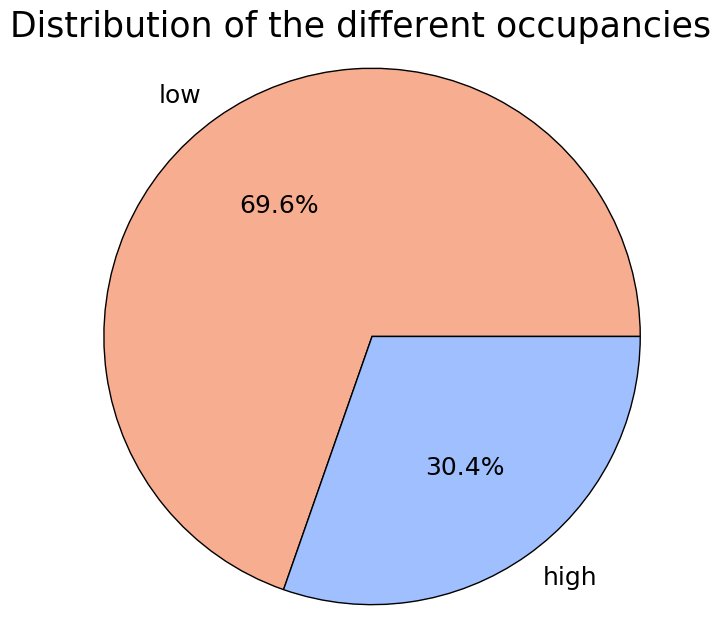

In [14]:
def plot_pie_chart(values, labels, title):
        # The slices will be ordered and plotted counter-clockwise.
        my_norm = matplotlib.colors.Normalize(0, 1)  # maps your data to the range [0, 1]
        my_cmap = matplotlib.cm.get_cmap('coolwarm')
        # print my_norm(values)
        fig = plt.figure()
        fig.suptitle(title, fontsize=25)

        matplotlib.rcParams['font.size'] = 18
        plt.pie(values, labels=labels, colors=my_cmap(my_norm(values)),
                autopct='%1.1f%%')
        # Set aspect ratio to be equal so that pie is drawn as a circle.
        plt.axis('equal')
        F = plt.gcf()
        Size = F.get_size_inches()
        F.set_size_inches(Size[0] * 1.25, Size[1] * 1.75, forward=True)
        plt.show()
        
def get_distribution(_values):
    distribution = {}
    for value in _values:
        if value not in distribution:
            distribution[value] = 1
        else:
            distribution[value] += 1

    total_sum = np.sum(list(distribution.values()))
    for value in distribution:
        distribution[value] = float(distribution[value]) / float(total_sum)

    return distribution

logs_df = pd.read_csv('logs.csv')
col_distribution = get_distribution(logs_df['clf_occupancy'].map({'low': 'low', 'medium': 'low', 'high': 'high'}).values)
plot_pie_chart(list(col_distribution.values()), col_distribution.keys(), 'Distribution of the different occupancies')

### Get some weather information for each station

In [8]:
# http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=fdafef39ee2140cf931100707163010&q=50.937810,4.040952&format=json&date=2016-10-01&enddate=2016-10-30&tp=1

# weather_df
stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'longitude', 'latitude']]
stations_df = stations_df.head(int(np.ceil(len(stations_df)/2)))

_columns = ['station_name', 'lat', 'lng', 'date_time', 'temperature', 'humidity', 'windspeed', 
            'visibility', 'weather_type']

weather_entries = []
faulty_calls = 0
for i in range(len(stations_df)):
    try:
        station_entry = stations_df.iloc[i,:]
        url_prefix = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=9471f0b13b144a5fb42103108161912'
        url_location = '&q='+str(station_entry['latitude'])+','+str(station_entry['longitude'])
        url_suffix = '&format=json&date=2016-10-01&enddate=2016-11-01&tp=1'
        weather_json = requests.get(url_prefix+url_location+url_suffix).json()
        station_name = station_entry['name']
        lat = station_entry['latitude']
        lng = station_entry['longitude']
        for weather_json_entry in weather_json['data']['weather']:
            weather_date = weather_json_entry['date']
            weather_year, weather_month, weather_day = list(map(int, weather_date.split('-')))
            for hourly_weather_entry in weather_json_entry['hourly']:
                weather_time = hourly_weather_entry['time']
                humidity = hourly_weather_entry['humidity']
                windspeed = hourly_weather_entry['windspeedKmph']
                visibility = hourly_weather_entry['visibility']
                temperature = hourly_weather_entry['tempC']
                weather_type = hourly_weather_entry['weatherCode']
                weather_hour = int(int(weather_time)/100)
                weather_date = datetime.datetime(year=weather_year, month=weather_month, day=weather_day, 
                                                 hour=weather_hour)

                weather_entries.append([station_name, lat, lng, weather_date, temperature, humidity, windspeed, 
                                        visibility, weather_type])
    except:
        faulty_calls += 1
        continue
            
weather_df = pd.DataFrame(weather_entries)
weather_df.columns = _columns
print(faulty_calls, 'errors occured')
print(weather_df.head(5))

weather_df.to_csv('weather_data_oct_2.csv')

1 errors occured
       station_name        lat       lng           date_time temperature  \
0  Aalst-Kerrebroek  50.948377  4.024407 2016-10-01 00:00:00          11   
1  Aalst-Kerrebroek  50.948377  4.024407 2016-10-01 01:00:00          11   
2  Aalst-Kerrebroek  50.948377  4.024407 2016-10-01 02:00:00          11   
3  Aalst-Kerrebroek  50.948377  4.024407 2016-10-01 03:00:00          10   
4  Aalst-Kerrebroek  50.948377  4.024407 2016-10-01 04:00:00          10   

  humidity windspeed visibility weather_type  
0       73         8         10          119  
1       75         8         10          119  
2       76         8         10          116  
3       78         8         10          116  
4       82         7         10          116  


### Which routes are most often full?

In [174]:
df = logs_df.groupby(['from', 'to'])['occupancy'].agg(lambda x: ','.join(x))
occupancy_hist_per_route = []
stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])
for i in df.index:
    _count = len(df.loc[i].split(','))
    occupancy_hist_per_route.append([(stations_df[stations_df['URI'] == i[0]]['name'].values[0], stations_df[stations_df['URI'] == i[1]]['name'].values[0]), _count, df.loc[i].count('low')/_count, df.loc[i].count('medium')/_count,
                                     df.loc[i].count('high')/_count])
occupancy_df = pd.DataFrame(occupancy_hist_per_route)
occupancy_df.columns = ['route', 'count', 'low', 'medium', 'high']

occupancy_df = occupancy_df[occupancy_df['count']>4].sort(columns=['high','count'], ascending=False)
occupancy_df = occupancy_df.head(25)
print(occupancy_df)

                                                 route  count       low  \
457                                   (Leuven, Landen)      8  0.000000   
121                (Brussel-Noord/Bruxelles-Nord, Ans)      6  0.000000   
268  (Brussels Airport - Zaventem, Brussel-Noord/Br...      8  0.125000   
504                (Ans, Brussel-Noord/Bruxelles-Nord)     13  0.000000   
690                      (Gent-Sint-Pieters, De Pinte)      6  0.000000   
23                               (Vilvoorde, Mechelen)      5  0.200000   
611                                       (Silly, Ath)      5  0.000000   
445                                    (Leuven, Alken)      8  0.000000   
220     (Brussel-Zuid/Bruxelles-Midi, Braine-le-Comte)     10  0.100000   
118           (Brussel-Noord/Bruxelles-Nord, Aarschot)      9  0.222222   
708                      (Gent-Sint-Pieters, Kortrijk)      9  0.111111   
435             (Leuven, Brussel-Noord/Bruxelles-Nord)     34  0.205882   
436       (Leuven, Brusse

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(0.625, 26.125)

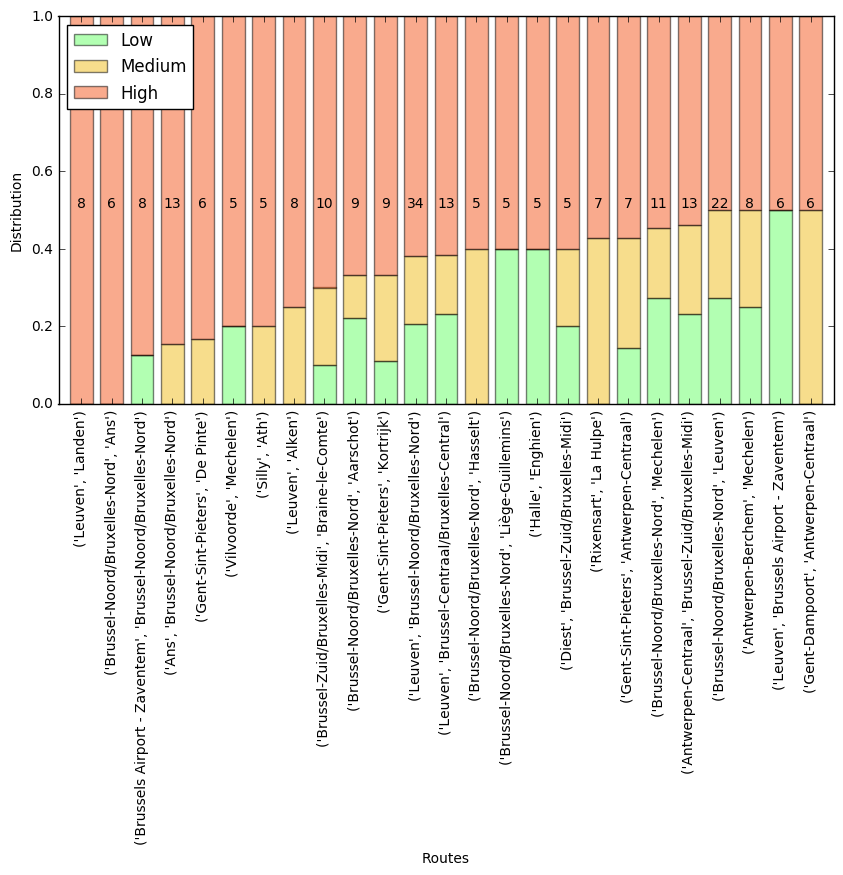

In [175]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(occupancy_df['low']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the pre_score data
        occupancy_df['low'], 
        # set the width
        width=bar_width,
        # with the label pre score
        label='Low', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#66ff66')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the mid_score data
        occupancy_df['medium'], 
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=occupancy_df['low'], 
        # with the label mid score
        label='Medium', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F1BD1A')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the post_score data
        occupancy_df['high'], 
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(occupancy_df['low'],occupancy_df['medium'])], 
        # with the label post score
        label='High', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F4561D')

# set the x ticks with names
plt.xticks(tick_pos, occupancy_df['route'], rotation='vertical')

# Set the label and legends
ax1.set_ylabel("Distribution")
ax1.set_xlabel("Routes")

for rect, label in zip(ax1.patches, occupancy_df['count'].values.astype(str)):
    ax1.text(rect.get_x() + rect.get_width()/2, 0.5, label, ha='center', va='bottom')
    
plt.legend(loc='upper left')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

### And which train types are most often full?

In [228]:
df = logs_df.groupby(['vehicle_type'])['occupancy'].agg(lambda x: ','.join(x))
occupancy_hist_per_vehicle_type = []
for i in df.index:
    _count = len(df.loc[i].split(','))
    occupancy_hist_per_vehicle_type.append([i, _count, df.loc[i].count('low')/_count, df.loc[i].count('medium')/_count,
                                            df.loc[i].count('high')/_count])
occupancy_df = pd.DataFrame(occupancy_hist_per_vehicle_type)
occupancy_df.columns = ['vehicle_type', 'count', 'low', 'medium', 'high']

occupancy_df = occupancy_df[occupancy_df['count']>4].sort(columns=['high','count'], ascending=False)
occupancy_df = occupancy_df.head(25)
print(occupancy_df)

  vehicle_type  count       low    medium      high
5            P    198  0.292929  0.272727  0.434343
1           IC   1448  0.395718  0.283840  0.320442
6            S    323  0.402477  0.303406  0.294118
4            L    157  0.656051  0.159236  0.184713
8          THA     13  0.461538  0.384615  0.153846


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(0.625, 6.125)

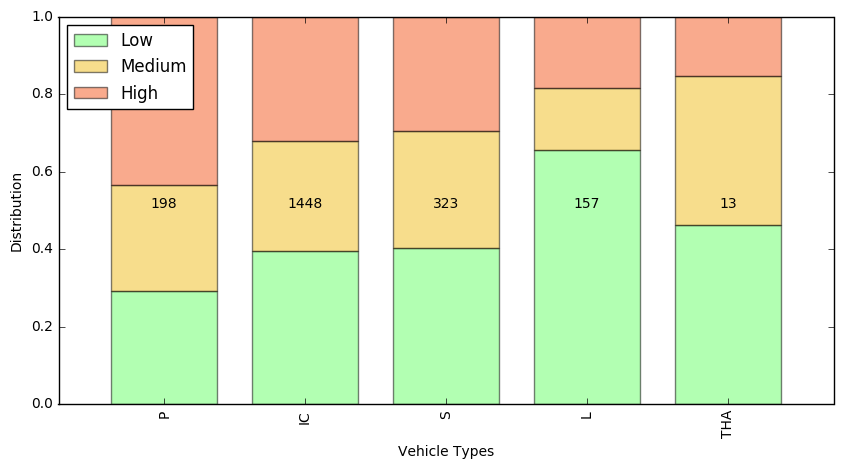

In [229]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(occupancy_df['low']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the pre_score data
        occupancy_df['low'], 
        # set the width
        width=bar_width,
        # with the label pre score
        label='Low', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#66ff66')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the mid_score data
        occupancy_df['medium'], 
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=occupancy_df['low'], 
        # with the label mid score
        label='Medium', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F1BD1A')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the post_score data
        occupancy_df['high'], 
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(occupancy_df['low'],occupancy_df['medium'])], 
        # with the label post score
        label='High', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F4561D')

# set the x ticks with names
plt.xticks(tick_pos, occupancy_df['vehicle_type'], rotation='vertical')

# Set the label and legends
ax1.set_ylabel("Distribution")
ax1.set_xlabel("Vehicle Types")

for rect, label in zip(ax1.patches, occupancy_df['count'].values.astype(str)):
    ax1.text(rect.get_x() + rect.get_width()/2, 0.5, label, ha='center', va='bottom')
    
plt.legend(loc='upper left')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

### And finally, which weekdays?

In [231]:
features_df = logs_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'month',
                      'from_lat', 'from_lng', 'to_lat', 'to_lng']]
features_df = pd.get_dummies(features_df, columns=['weekday','from_string', 'to_string', 'vehicle_type'])
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = logs_df['occupancy'].map(occupancy_mapping)

NR_FOLDS = 5
NR_FEATURES = 40

train_sizes = np.linspace(0.05,1.0,num=20)
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)
params = {'C':[1,5,10,0.1,0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lr = LogisticRegression(tol=1e-9)
clf = GridSearchCV(lr ,params, refit='True', n_jobs=1, cv=3, verbose=0)
plot_learning_curve(clf, 'learning curve for basic features (LR 5-fold CV)', features_df, labels_df, train_sizes=train_sizes, cv=skf)
plt.show()
df = logs_df.groupby(['weekday'])['occupancy'].agg(lambda x: ','.join(x))
occupancy_hist_per_weekday = []
for i in df.index:
    _count = len(df.loc[i].split(','))
    occupancy_hist_per_weekday.append([i, _count, df.loc[i].count('low')/_count, df.loc[i].count('medium')/_count,
                                            df.loc[i].count('high')/_count])
occupancy_df = pd.DataFrame(occupancy_hist_per_weekday)
occupancy_df.columns = ['weekday', 'count', 'low', 'medium', 'high']

occupancy_df = occupancy_df[occupancy_df['count']>4].sort(columns=['high','count'], ascending=False)
occupancy_df = occupancy_df.head(25)
print(occupancy_df)

     weekday  count       low    medium      high
0     Friday    410  0.358537  0.241463  0.400000
3     Sunday    181  0.353591  0.281768  0.364641
1     Monday    374  0.310160  0.342246  0.347594
4   Thursday    446  0.419283  0.280269  0.300448
5    Tuesday    340  0.441176  0.285294  0.273529
2   Saturday    125  0.568000  0.184000  0.248000
6  Wednesday    271  0.512915  0.265683  0.221402


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(0.625, 8.125)

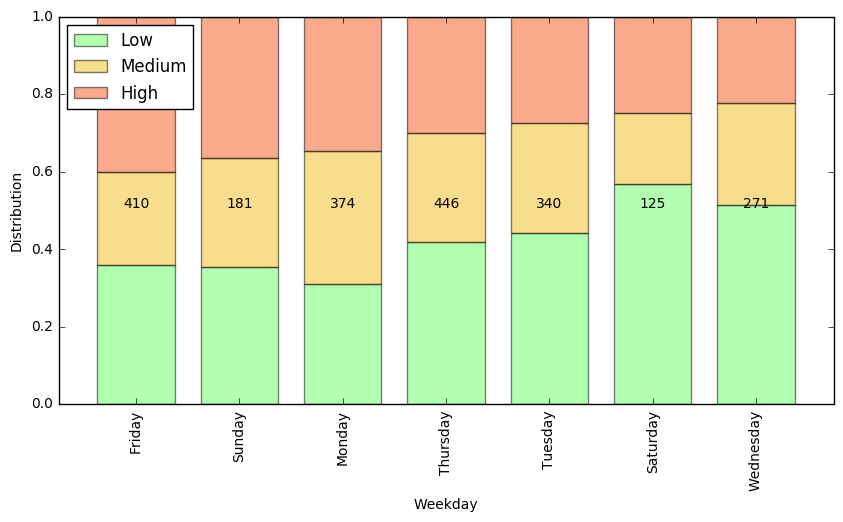

In [232]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(occupancy_df['low']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the pre_score data
        occupancy_df['low'], 
        # set the width
        width=bar_width,
        # with the label pre score
        label='Low', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#66ff66')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the mid_score data
        occupancy_df['medium'], 
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=occupancy_df['low'], 
        # with the label mid score
        label='Medium', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F1BD1A')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the post_score data
        occupancy_df['high'], 
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(occupancy_df['low'],occupancy_df['medium'])], 
        # with the label post score
        label='High', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F4561D')

# set the x ticks with names
plt.xticks(tick_pos, occupancy_df['weekday'], rotation='vertical')

# Set the label and legends
ax1.set_ylabel("Distribution")
ax1.set_xlabel("Weekday")

for rect, label in zip(ax1.patches, occupancy_df['count'].values.astype(str)):
    ax1.text(rect.get_x() + rect.get_width()/2, 0.5, label, ha='center', va='bottom')
    
plt.legend(loc='upper left')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

### Very simplistic model using `seconds_since_midnight`, `month`, `lat` & `lng` of `from_station` and `to_station` and one-hot encoding on `weekday`, `from`, `to` and `vehicle_type`

In [28]:
# Maybe we should use only from_station, from_lat and from_lng? the to_ features seem somewhat unimportant? 
# We want to predict if the train will be full when the user gets on

features_df = logs_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'month',
                      'from_lat', 'from_lng', 'to_lat', 'to_lng']]
features_df.to_csv('simple_features.csv')
features_df = pd.get_dummies(features_df, columns=['weekday','from_string', 'to_string', 'vehicle_type'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = logs_df['occupancy'].map(occupancy_mapping)

xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                     gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                     min_child_weight=5, max_depth=13)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    
    xgb.fit(X_train, y_train)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

Features dataframe dimensions: 2147 x 508
Fold 1 / 5


KeyboardInterrupt: 

### Plot learning curve

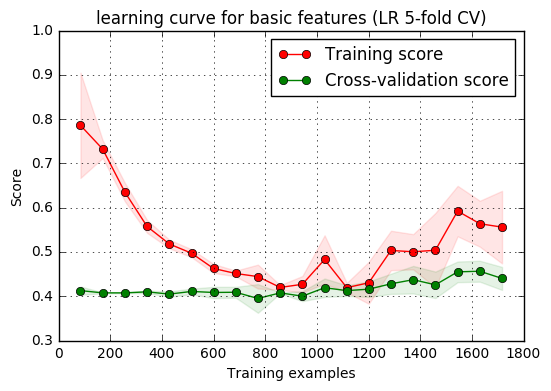

In [5]:
features_df = logs_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'month',
                      'from_lat', 'from_lng', 'to_lat', 'to_lng']]
features_df = pd.get_dummies(features_df, columns=['weekday','from_string', 'to_string', 'vehicle_type'])
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = logs_df['occupancy'].map(occupancy_mapping)

NR_FOLDS = 5
NR_FEATURES = 40

train_sizes = np.linspace(0.05,1.0,num=20)
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)
params = {'C':[1,5,10,0.1,0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lr = LogisticRegression(tol=1e-9)
clf = GridSearchCV(lr ,params, refit='True', n_jobs=1, cv=3, verbose=0)
plot_learning_curve(clf, 'learning curve for basic features (LR 5-fold CV)', features_df, labels_df, train_sizes=train_sizes, cv=skf)
plt.show()

### 2. Using the weather data

In [13]:
features_df = logs_df[['seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'vehicle', 
                       'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng', 'querytime', 'occupancy']]
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
weather_df = pd.concat([pd.read_csv('weather_data.csv'), pd.read_csv('weather_data_july_1.csv'), 
                        pd.read_csv('weather_data_july_2.csv'), pd.read_csv('weather_data_aug_1.csv'),
                        pd.read_csv('weather_data_aug_2.csv'), pd.read_csv('weather_data_sep_1.csv'),
                        pd.read_csv('weather_data_sep_2.csv'), pd.read_csv('weather_data_oct_1.csv'),
                        pd.read_csv('weather_data_oct_2.csv'), pd.read_csv('weather_data_nov_1.csv'),
                        pd.read_csv('weather_data_nov_2.csv'), pd.read_csv('weather_data_dec_1.csv'),
                        pd.read_csv('weather_data_dec_2.csv')])
print(weather_df[['date_time']].head(5))

# Only keep the ones from October
#train_df = train_df[(train_df['querytime'] > datetime.datetime(year=2016, month=9, day=30, hour=23))
#                   & (train_df['querytime'] < datetime.datetime(year=2016, month=11, day=1))]
#print('October Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
#weather_df['date_time'] = weather_df['date_time'].apply(lambda x: parse(x))
weather_features = []
_columns = list(features_df.columns) + ['temperature_from', 'humidity_from', 'windspeed_from', 
                                        'visibility_from', 'weather_type_from', 'temperature_to', 
                                        'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to']
for i in range(len(features_df)):
    print(i,'/',len(features_df))
    feature_vector = features_df.iloc[i,:]
    if feature_vector['querytime'].minute < 30:
        feature_vector_hour = feature_vector['querytime'].hour
    else:
        feature_vector_hour = feature_vector['querytime'].hour + 1
        
    month_string = str(feature_vector['querytime'].month) if feature_vector['querytime'].month > 9 else '0'+str(feature_vector['querytime'].month)
    day_string = str(feature_vector['querytime'].day) if feature_vector['querytime'].day > 9 else '0'+str(feature_vector['querytime'].day)
    hour_string = str(feature_vector_hour%24) if feature_vector_hour%24 > 9 else '0'+str(feature_vector_hour%24)
    feature_vector_date_string = str(feature_vector['querytime'].year)+'-'+month_string+'-'+day_string+' '+hour_string+':00:00'
    #feature_vector_date = datetime.datetime(year=feature_vector['querytime'].year, 
    #                                        month=feature_vector['querytime'].month,
    #                                        day=feature_vector['querytime'].day, 
    #                                        hour=feature_vector_hour%24)
    #print(feature_vector_date)
    
    print(feature_vector_date_string)
    weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == feature_vector['from_string'])].head(1)
    if feature_vector['from_string'] == 'Aalst' or feature_vector['from_string'] == 'Lokeren':
        # Something went wrong for Aalst & Lokeren weather data, let's just take the data from Gent
        weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == 'Gent-Sint-Pieters')].head(1)
    if feature_vector['from_string'] == 'Mol' or feature_vector['from_string'] == 'Lommel':
        weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == 'Hasselt')].head(1)    
        
    if len(weather_entry) > 0:
        print('Weather data for (FROM) '+feature_vector['from_string']+' found')
        weather_feature_v = list(feature_vector.values) + [weather_entry['temperature'].values[0], weather_entry['humidity'].values[0], 
                                                            weather_entry['windspeed'].values[0], weather_entry['visibility'].values[0],
                                                            weather_entry['weather_type'].values[0]]
        #weather_features.append(weather_feature_v)
    else:
        print('Weather data for (FROM) '+feature_vector['from_string']+' NOT found')
        
        
    weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == feature_vector['to_string'])].head(1)
    if feature_vector['to_string'] == 'Aalst' or feature_vector['to_string'] == 'Lokeren':
        # Something went wrong for Aalst & Lokeren weather data, let's just take the data from Gent
        weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == 'Gent-Sint-Pieters')].head(1)
        
    if feature_vector['to_string'] == 'Mol' or feature_vector['to_string'] == 'Lommel':
        weather_entry = weather_df[(weather_df['date_time'] == feature_vector_date_string)
                               & (weather_df['station_name'] == 'Hasselt')].head(1)
    if len(weather_entry) > 0:
        print('Weather data for (TO) '+feature_vector['to_string']+' found')
        weather_feature_v = weather_feature_v + [weather_entry['temperature'].values[0], weather_entry['humidity'].values[0], 
                                                            weather_entry['windspeed'].values[0], weather_entry['visibility'].values[0],
                                                            weather_entry['weather_type'].values[0]]
        if len(weather_feature_v) == len(_columns):
            weather_features.append(weather_feature_v)
    else:
        print('Weather data for (TO) '+feature_vector['to_string']+' NOT found')
    
weather_feature_df = pd.DataFrame(weather_features)
weather_feature_df.columns = _columns

weather_feature_df.to_csv('weather_features.csv')

# Is this weather_code thing somewhat ordinal?
weather_feature_df['weather_cat_from'] = weather_feature_df['weather_type_from'].copy()
weather_feature_df['weather_cat_to'] = weather_feature_df['weather_type_to'].copy()
weather_feature_df = pd.get_dummies(weather_feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday','from_string', 'to_string', 'vehicle_type'])

occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = weather_feature_df['occupancy'].map(occupancy_mapping)
feature_df = weather_feature_df.drop(['occupancy', 'querytime'], axis=1)

Features dataframe dimensions: 3200 x 13
             date_time
0  2016-10-01 00:00:00
1  2016-10-01 01:00:00
2  2016-10-01 02:00:00
3  2016-10-01 03:00:00
4  2016-10-01 04:00:00
0 / 3200
2016-11-13 20:00:00
Weather data for (FROM) Lier found
Weather data for (TO) Herentals found
1 / 3200
2016-09-25 14:00:00
Weather data for (FROM) London Saint Pancras International found
Weather data for (TO) Ebbsfleet International found
2 / 3200
2016-11-22 19:00:00
Weather data for (FROM) London Saint Pancras International found
Weather data for (TO) Brussel-Zuid/Bruxelles-Midi found
3 / 3200
2016-11-26 17:00:00
Weather data for (FROM) Antwerpen-Centraal found
Weather data for (TO) Lier found
4 / 3200
2016-11-13 20:00:00
Weather data for (FROM) Antwerpen-Centraal found
Weather data for (TO) Lier found
5 / 3200
2016-11-25 20:00:00
Weather data for (FROM) Lier found
Weather data for (TO) Antwerpen-Centraal found
6 / 3200
2016-10-30 11:00:00
Weather data for (FROM) Brussel-Centraal/Bruxelles-Central fo

In [9]:
# This function can be called to optimize the hyper-parameters of the XGB Classifier
def construct_classifier(train, features, label_col):
    data = train[features]
    target = train[label_col]

    def xgbcv(nr_classifiers, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma,
              reg_lambda):
        nr_classifiers = int(nr_classifiers)
        max_depth = int(max_depth)
        min_child_weight = int(min_child_weight)
        return cross_val_score(XGBClassifier(learning_rate=learning_rate, n_estimators=nr_classifiers,
                                             gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                             nthread=1, scale_pos_weight=1, reg_lambda=reg_lambda,
                                             min_child_weight=min_child_weight, max_depth=max_depth),
                               data, target, 'accuracy', cv=5).mean()

    params = {
        'nr_classifiers': (50, 2000),
        'learning_rate': (0.01, 0.3),
        'max_depth': (5, 15),
        'min_child_weight': (2, 10),
        'subsample': (0.7, 0.8),
        'colsample_bytree': (0.5, 0.99),
        'gamma': (1., 0.01),
        'reg_lambda': (0, 1)
    }

    xgbBO = BayesianOptimization(xgbcv, params, verbose=1)
    xgbBO.maximize(init_points=3, n_iter=20, n_restarts_optimizer=100)

    best_params = xgbBO.res['max']['max_params']

    best_nr_classifiers = int(best_params['nr_classifiers'])
    best_max_depth = int(best_params['max_depth'])
    best_min_child_weight = int(best_params['min_child_weight'])
    best_colsample_bytree = best_params['colsample_bytree']
    best_subsample = best_params['subsample']
    best_reg_lambda = best_params['reg_lambda']
    best_learning_rate = best_params['learning_rate']
    best_gamma = best_params['gamma']

    xgb = XGBClassifier(learning_rate=best_learning_rate, n_estimators=best_nr_classifiers,
                         gamma=best_gamma, subsample=best_subsample, colsample_bytree=best_colsample_bytree,
                         nthread=1, scale_pos_weight=1, reg_lambda=best_reg_lambda,
                         min_child_weight=best_min_child_weight, max_depth=best_max_depth)
    start = time.time()
    xgb.fit(data, target)

    return xgb

In [40]:
NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

feature_df = feature_df.drop(['vehicle'], axis=1)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.075, n_estimators=1750,
                         gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                         min_child_weight=5, max_depth=13)
    xgb.fit(X_train, y_train)
    feature_importance_values = xgb.feature_importances_
    selected_features_idx = xgb.feature_importances_.argsort()[-PLOT_NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [feature_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/o FS:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    selected_features_idx = feature_importance_values.argsort()[-100:][::-1]
    X_train = train[[feature_df.columns[i] for i in selected_features_idx]]
    X_test = test[[feature_df.columns[i] for i in selected_features_idx]]
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/ 100 features:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    selected_features_idx = feature_importance_values.argsort()[-250:][::-1]
    X_train = train[[feature_df.columns[i] for i in selected_features_idx]]
    X_test = test[[feature_df.columns[i] for i in selected_features_idx]]
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/ 250 features:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    selected_features_idx = feature_importance_values.argsort()[-400:][::-1]
    X_train = train[[feature_df.columns[i] for i in selected_features_idx]]
    X_test = test[[feature_df.columns[i] for i in selected_features_idx]]
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/ 400 features:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

Weather Features dataframe dimensions: 2140 x 550


ValueError: labels ['vehicle'] not contained in axis

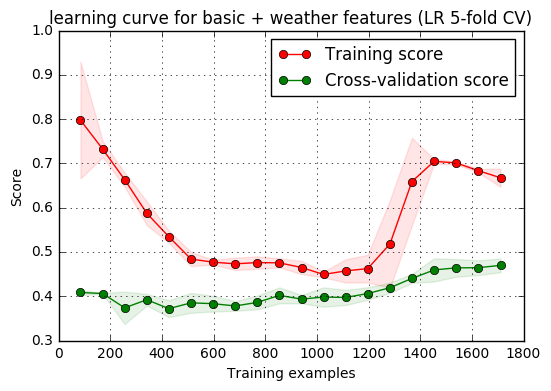

In [21]:
weather_df = pd.read_csv('weather_features.csv')
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = weather_df['occupancy'].map(occupancy_mapping)
features_df = weather_df.drop(['occupancy', 'querytime', 'vehicle'], axis=1)
features_df = pd.get_dummies(features_df, columns=['weather_type_from', 'weather_type_to', 'weekday','from_string', 'to_string', 'vehicle_type'])


NR_FOLDS = 5
NR_FEATURES = 40

train_sizes = np.linspace(0.05,1.0,num=20)
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)
params = {'C':[1,5,10,0.1,0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lr = LogisticRegression(tol=1e-9)
clf = GridSearchCV(lr ,params, refit='True', n_jobs=1, cv=3, verbose=0)
plot_learning_curve(clf, 'learning curve for basic + weather features (LR 5-fold CV)', features_df, labels_df, train_sizes=train_sizes, cv=skf)
plt.show()

### 3. Getting some delay data

In [27]:
# scrape http://graph.spitsgids.be/connections/?departureTime=2016-07-27T00%3A00 till 2016-11-01T00%3A00
# While scraping, check if a vehicle number corresponds to a vehicle number in the dataframe, and check
# their difference in time. For each entry: pick the delay closest in time with same vehicle number
# STORE: the delay, and the difference in time to the closest measurement

#delays_pre_df = logs_df[['querytime', 'vehicle']]
#delays_dict = {}
#for i in range(len(delays_pre_df)):
#    delays_pre_entry = delays_pre_df.iloc[i,:]
#    delays_dict[(delays_pre_entry['querytime'], delays_pre_entry['vehicle'])] = []
    
start_time = datetime.datetime(year=2016, month=11, day=6, hour=0, minute=0)
end_time = datetime.datetime(year=2016, month=12, day=20, hour=0, minute=0)
time_delta = datetime.timedelta(minutes=10)
current_time = start_time
while current_time < end_time:
    url_prefix = 'http://graph.spitsgids.be/connections/?departureTime='
    url_month = str(current_time.month) if current_time.month > 9 else '0'+str(current_time.month)
    url_day = str(current_time.day) if current_time.day > 9 else '0'+str(current_time.day)
    url_date = str(current_time.year)+'-'+url_month+'-'+url_day+'T'+str(current_time.hour)+':'+str(current_time.minute)
    delay_json = requests.get(url_prefix+url_date).json()
    for delay in delay_json["@graph"]:
        if 'departureDelay' in delay:
            vehicle_name = delay['gtfs:route'].split('/')[-1]

            filtered_df = delays_pre_df[delays_pre_df['vehicle'] == vehicle_name]
            for i in range(len(filtered_df)):
                filtered_entry = filtered_df.iloc[i,:]
                timezone_offset = filtered_entry['querytime'].tzinfo._offset
                querytime_notz = filtered_entry['querytime'].replace(tzinfo=None)-timezone_offset
                departtime_notz = parse(delay['departureTime']).replace(tzinfo=None)
                time_diff = abs(departtime_notz-querytime_notz)
                    
                if len(delays_dict[(filtered_entry['querytime'], filtered_entry['vehicle'])]) == 0:
                    delays_dict[(filtered_entry['querytime'], 
                                 filtered_entry['vehicle'])] = (delay['departureDelay'], time_diff)
                else:
                    if delays_dict[(filtered_entry['querytime'], filtered_entry['vehicle'])][1] > time_diff:
                        delays_dict[(filtered_entry['querytime'], filtered_entry['vehicle'])] = (delay['departureDelay'], time_diff)
            
    current_time = current_time + time_delta
    #print([delays_dict[key] for key in list(delays_dict.keys())[:100]])
    print(current_time)

2016-11-06 00:10:00
2016-11-06 00:20:00
2016-11-06 00:30:00
2016-11-06 00:40:00
2016-11-06 00:50:00
2016-11-06 01:00:00
2016-11-06 01:10:00
2016-11-06 01:20:00
2016-11-06 01:30:00
2016-11-06 01:40:00
2016-11-06 01:50:00
2016-11-06 02:00:00
2016-11-06 02:10:00
2016-11-06 02:20:00
2016-11-06 02:30:00
2016-11-06 02:40:00
2016-11-06 02:50:00
2016-11-06 03:00:00
2016-11-06 03:10:00
2016-11-06 03:20:00
2016-11-06 03:30:00
2016-11-06 03:40:00
2016-11-06 03:50:00
2016-11-06 04:00:00
2016-11-06 04:10:00
2016-11-06 04:20:00
2016-11-06 04:30:00
2016-11-06 04:40:00
2016-11-06 04:50:00
2016-11-06 05:00:00
2016-11-06 05:10:00
2016-11-06 05:20:00
2016-11-06 05:30:00
2016-11-06 05:40:00
2016-11-06 05:50:00
2016-11-06 06:00:00
2016-11-06 06:10:00
2016-11-06 06:20:00
2016-11-06 06:30:00
2016-11-06 06:40:00
2016-11-06 06:50:00
2016-11-06 07:00:00
2016-11-06 07:10:00
2016-11-06 07:20:00
2016-11-06 07:30:00
2016-11-06 07:40:00
2016-11-06 07:50:00
2016-11-06 08:00:00
2016-11-06 08:10:00
2016-11-06 08:20:00


In [28]:
print(sum([len(delays_dict[k]) > 0 for k in delays_dict]))

2468


In [29]:
delay_features = []
for key in delays_dict.keys():
    if len(delays_dict[key]) > 0:
        delay_features.append([key[0], key[1], delays_dict[key][0], delays_dict[key][1]])
    else:
        print('Not delay found for', key)
        delay_features.append([key[0], key[1], 0, 0])
        
delay_features_df = pd.DataFrame(delay_features)
delay_features_df.columns = ['querytime', 'vehicle', 'delay', 'time_diff']
delay_features_df.to_csv('delay_features.csv')
#print(sorted(map(lambda x: x.total_seconds() if x != '0' else 0, delay_features_df['time_diff'].values), reverse=1))

Not delay found for (datetime.datetime(2016, 10, 6, 22, 32, 49, tzinfo=tzoffset(None, 7200)), 'IC3603')
Not delay found for (datetime.datetime(2016, 9, 23, 18, 5, tzinfo=tzoffset(None, 7200)), 'S11778')
Not delay found for (datetime.datetime(2016, 12, 13, 8, 0, 8, tzinfo=tzoffset(None, 3600)), 'S73478')
Not delay found for (datetime.datetime(2016, 10, 10, 7, 58, 43, tzinfo=tzoffset(None, 7200)), 'IC3328')
Not delay found for (datetime.datetime(2016, 9, 27, 8, 33, 12, tzinfo=tzoffset(None, 7200)), 'L557')
Not delay found for (datetime.datetime(2016, 9, 29, 6, 52, 20, tzinfo=tzoffset(None, 7200)), 'IC1728')
Not delay found for (datetime.datetime(2016, 12, 5, 6, 35, 21, tzinfo=tzoffset(None, 3600)), 'L2476')
Not delay found for (datetime.datetime(2016, 12, 1, 7, 24, 32, tzinfo=tzoffset(None, 3600)), 'IC2029')
Not delay found for (datetime.datetime(2016, 11, 22, 4, 19, 36, tzinfo=tzoffset(None, 3600)), 'IC1527')
Not delay found for (datetime.datetime(2016, 10, 7, 6, 42, 50, tzinfo=tzoffset

AttributeError: 'int' object has no attribute 'total_seconds'

In [36]:
delay_features_df = pd.read_csv('delay_features.csv')
weather_feature_df = pd.read_csv('weather_features.csv')

delay_feature_vectors = []
_columns = list(weather_feature_df.columns) + ['delay_15', 'delay_30', 'delay_60', 'delay_100']
for i in range(len(weather_feature_df)):
    old_feature_vector = weather_feature_df.iloc[i,:]
    filtered_vehicle_df = delay_features_df[delay_features_df['vehicle'] == old_feature_vector['vehicle']]
    
    # Find the one that is closest to querytime
    min_time_delta = None
    record = None
    for j in range(len(filtered_vehicle_df)):
        filtered_vector = filtered_vehicle_df.iloc[j,:]
        time_delta = abs(parse(old_feature_vector['querytime'])-parse(filtered_vector['querytime']))
        if min_time_delta is None or time_delta < min_time_delta:
            min_time_delta = time_delta
            record = filtered_vector
            
    
    time_diff = record['time_diff']
    time_diff_in_seconds = 0
    delay_15 = 0
    delay_30 = 0
    delay_60 = 0
    delay_100 = 0
    if ':' in time_diff:  # If there is no days in the string, then it's missing and we assume no delay
        if 'days' in time_diff:
            time_days = int(time_diff.split(' days, ')[0])
            time_timestamp = time_diff.split(' days, ')[1]
        else: 
            time_timestamp = time_diff
            time_days = 0
        
        if time_days == 0:
            time_hours, time_minutes, time_seconds = time_timestamp.split(':')
            if int(time_minutes) < 15:
                delay_15 = record['delay']
            if int(time_minutes) < 30:
                delay_30 = record['delay']
            if int(time_minutes) < 60:
                delay_60 = record['delay']
            if int(time_minutes) < 100:
                delay_100 = record['delay']
    
    print(str(i), '/', str(len(weather_feature_df))+':', old_feature_vector['querytime'], old_feature_vector['vehicle'], 
           '---', record['time_diff'], '---', record['delay'])

    delay_feature_vectors.append(list(old_feature_vector.values) + [delay_15, delay_30, delay_60, delay_100])
   
print(len(delay_feature_vectors))
delay_features = pd.DataFrame(delay_feature_vectors)
delay_features.columns = _columns
delay_features.to_csv('weather_delay_features.csv')
    
#print(delay_features_df['time_diff'].values)
#for x in delay_features_df['time_diff'].values:
#    if 'days' in x:
#        time_days = x.split(' days')[0]
#delay_seconds = list(map(lambda x: x.total_seconds() if x != 0 else 0, delay_features_df['time_diff'].values))
#print(delay_seconds)


0 / 3192: 2016-11-13 20:11:15+01:00 BUS14320 --- 0 --- 0
1 / 3192: 2016-09-25 14:13:14+02:00 EUR9108 --- 0 --- 0
2 / 3192: 2016-11-22 19:26:27+01:00 EUR9148 --- 0 --- 0
3 / 3192: 2016-11-26 17:20:14+01:00 EXT12418 --- 0:47:46 --- 0
4 / 3192: 2016-11-13 19:32:51+01:00 EXT12420 --- 0:35:09 --- 0
5 / 3192: 2016-11-25 20:21:58+01:00 EXT12435 --- 19:19:02 --- 60
6 / 3192: 2016-10-30 11:00:13+01:00 IC12110 --- 0:02:13 --- 180
7 / 3192: 2016-12-03 10:48:49+01:00 IC12332 --- 0:09:11 --- 0
8 / 3192: 2016-10-09 15:07:57+02:00 IC12614 --- 12 days, 23:29:03 --- 180
9 / 3192: 2016-12-04 20:30:01+01:00 IC12742 --- 0:00:59 --- 120
10 / 3192: 2016-11-27 09:28:56+01:00 IC12810 --- 13 days, 20:36:56 --- 60
11 / 3192: 2016-11-05 13:59:51+01:00 IC13316 --- 2:15:09 --- 60
12 / 3192: 2016-09-27 23:20:16+02:00 IC1504 --- 0 --- 0
13 / 3192: 2016-11-04 21:49:25+01:00 IC1505 --- 0 --- 0
14 / 3192: 2016-10-20 08:11:53+02:00 IC1506 --- 1:49:07 --- 1140
15 / 3192: 2016-10-20 09:26:39+02:00 IC1506 --- 0:34:21 --- 1

In [43]:
stations_drukte_link_df = pd.read_csv('station_drukte_link.csv')
drukke_stations = list(stations_drukte_link_df[stations_drukte_link_df.week > 5000]['station_link'].values)
drukke_stations.remove(np.NaN)
print(drukke_stations)

['Aalst', 'Aarschot', 'Antwerpen-Oost', 'Antwerpen-Berchem', 'Antwerpen-Centraal', 'Ath', "Braine-l'Alleud", 'Brussel-Centraal/Bruxelles-Central', 'Mouterij/Germoir', 'Brussel-Luxemburg/Bruxelles-Luxembourg', 'Brussel-Zuid/Bruxelles-Midi', 'Brussels Airport - Zaventem', 'Thurn en Taxis/Tour et Taxis', 'Brussel-Noord/Bruxelles-Nord', 'Brussel-Schuman/Bruxelles-Schuman', 'Brugge', 'Charleroi-Sud', 'Denderleeuw', 'Dendermonde', 'Gembloux', 'Gent-Dampoort', 'Gent-Sint-Pieters', 'Halle', 'Hasselt', 'Kortrijk', 'Leuven', 'Liège-Guillemins', 'Louvain-la-Neuve-Université', 'Mechelen', 'Mons', 'Namur', 'Oostende', 'Ottignies', 'Sint-Niklaas', 'Tournai', 'Vilvoorde', 'Zottegem']


In [62]:
holiday_vectors = []
with open('holidays.json') as json_data:
    d = json.load(json_data)
    for holiday_line in d['holidays']:
        holiday_date = parse(holiday_line['date'])
        holiday_day, holiday_month, holiday_year = holiday_date.day, holiday_date.month, holiday_date.year
        holiday_type = 1 if holiday_line['school'] else 2
        holiday_vectors.append([holiday_day, holiday_month, holiday_year, holiday_type])
holiday_df = pd.DataFrame(holiday_vectors)
holiday_df.columns = ['day', 'month', 'year', 'type']

print(holiday_df.head(5))

train_df = pd.read_csv('weather_delay_features.csv')
__cols = list(train_df.columns)
feature_vectors = []
# Insert holiday features
for i in range(len(train_df)):
    entry = train_df.iloc[i,:]
    entry_date = parse(entry['querytime'])
    day, month, year = entry_date.day, entry_date.month, entry_date.year
    filtered_df = holiday_df[(holiday_df.day == day) &
                             (holiday_df.month == month) &
                             (holiday_df.year == year)]
    if len(filtered_df) > 0: holiday_type = filtered_df.iloc[0,:]['type']
    else: holiday_type = 0
        
    feature_vectors.append(list(entry.values) + [holiday_type])
    
train_df = pd.DataFrame(feature_vectors)
train_df.columns = __cols + ['holiday_type']
train_df.to_csv('weather_delay_features.csv')

   day  month  year  type
0    1      1  2016     2
1    6      1  2016     2
2    9      2  2016     2
3   14      2  2016     2
4   25      3  2016     2


Weather Features dataframe dimensions: 3192 x 692
Fold 1 / 5


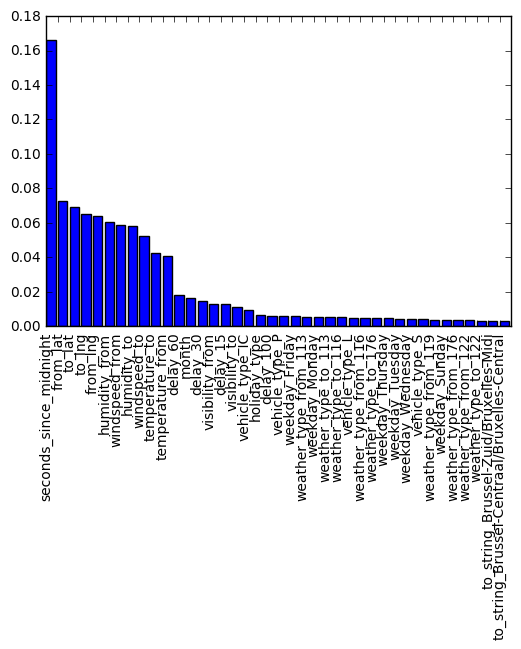

[[166  47  48]
 [ 66  63  57]
 [ 63  37  93]]
accuracy w/o FS: 0.503125
Fold 2 / 5


KeyboardInterrupt: 

In [63]:
train_df = pd.read_csv('weather_delay_features.csv')
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = train_df['occupancy'].map(occupancy_mapping)
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])

NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.1, n_estimators=750,
                         gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                         min_child_weight=5, max_depth=13)
    xgb.fit(X_train, y_train)
    feature_importance_values = xgb.feature_importances_
    selected_features_idx = xgb.feature_importances_.argsort()[-PLOT_NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [feature_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/o FS:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    

In [115]:
# Make two different models, one for weekdays and one for holidays and weekends
train_df = pd.read_csv('weather_delay_features.csv')
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = train_df['occupancy'].map(occupancy_mapping)
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])

NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    week_train = train[((train['weekday_Monday'] > 0) | (train['weekday_Tuesday'] > 0) | 
                        (train['weekday_Wednesday'] > 0) | (train['weekday_Thursday'] > 0) |
                        (train['weekday_Friday'] > 0))
                       & (train['holiday_type'] == 0)]
    no_week_train = train[((train['weekday_Saturday'] > 0) | (train['weekday_Sunday'] > 0))
                       | (train['holiday_type'] > 0)]
    print(len(week_train), '---', len(no_week_train))
    week_y_train = week_train[y_train.name]
    week_X_train = week_train.drop(y_train.name, axis=1)
    #week_X_train.columns = X_train.columns
    no_week_y_train = no_week_train[y_train.name]
    no_week_X_train = no_week_train.drop(y_train.name, axis=1)
    #no_week_X_train.columns = X_train.columns
    
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    week_test = test[((test['weekday_Monday'] > 0) | (test['weekday_Tuesday'] > 0) | 
                        (test['weekday_Wednesday'] > 0) | (test['weekday_Thursday'] > 0) |
                        (test['weekday_Friday'] > 0))
                       & (test['holiday_type'] == 0)]
    no_week_test = test[((test['weekday_Saturday'] > 0) | (test['weekday_Sunday'] > 0))
                       | (test['holiday_type'] > 0)]
    week_y_test = week_test[y_train.name]
    week_X_test = week_test.drop(y_train.name, axis=1)
    no_week_y_test = no_week_test[y_train.name]
    no_week_X_test = no_week_test.drop(y_train.name, axis=1)
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb_week = XGBClassifier(learning_rate=0.1, n_estimators=500,
                         gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                         min_child_weight=5, max_depth=13)
    xgb_week.fit(week_X_train, week_y_train)
    
    xgb_no_week = XGBClassifier(learning_rate=0.1, n_estimators=500,
                         gamma=0.9, subsample=0.75, colsample_bytree=0.7,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.25,
                         min_child_weight=5, max_depth=13)
    xgb_no_week.fit(no_week_X_train, no_week_y_train)

    predictions_week = xgb_week.predict(week_X_test)      
    conf_matrix = confusion_matrix(week_y_test, predictions_week)
    print(conf_matrix)
    print('accuracy week:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    predictions_no_week = xgb_week.predict(no_week_X_test)      
    conf_matrix = confusion_matrix(no_week_y_test, predictions_no_week)
    print(conf_matrix)
    print('accuracy no week:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    

Weather Features dataframe dimensions: 3192 x 692
Fold 1 / 5
1783 --- 769
[[102  38  27]
 [ 44  59  39]
 [ 26  28  90]]
accuracy week: 0.55408388521
[[54 28 12]
 [22 14  8]
 [22 11 16]]
accuracy no week: 0.449197860963
Fold 2 / 5
1791 --- 762
[[100  31  28]
 [ 51  53  34]
 [ 49  24  75]]
accuracy week: 0.512359550562
[[70 15 16]
 [26 11 11]
 [24 10 11]]
accuracy no week: 0.474226804124
Fold 3 / 5
1775 --- 779
[[97 40 37]
 [45 63 33]
 [35 38 73]]
accuracy week: 0.505422993492
[[57 14 15]
 [23 12  9]
 [23 14 10]]
accuracy no week: 0.446327683616
Fold 4 / 5
1795 --- 759
[[96 30 32]
 [46 53 38]
 [36 41 69]]
accuracy week: 0.49433106576
[[67 21 14]
 [32 11  5]
 [25 17  5]]
accuracy no week: 0.421319796954
Fold 5 / 5
1800 --- 755
[[77 28 44]
 [52 52 36]
 [39 32 76]]
accuracy week: 0.470183486239
[[61 25 25]
 [24  9 12]
 [20  7 18]]
accuracy no week: 0.437810945274


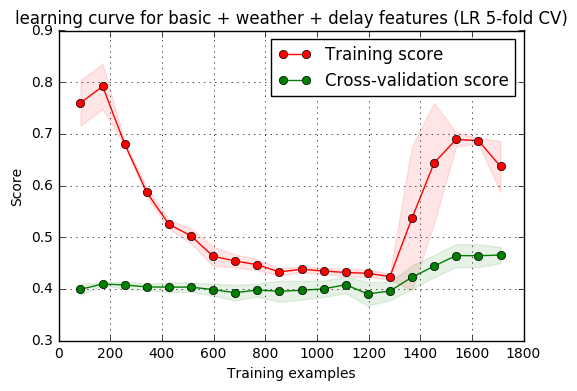

In [7]:
train_df = pd.read_csv('weather_delay_features.csv')
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = train_df['occupancy'].map(occupancy_mapping)
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])

NR_FOLDS = 5
NR_FEATURES = 40

train_sizes = np.linspace(0.05,1.0,num=20)
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)
params = {'C':[1,5,10,0.1,0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
lr = LogisticRegression(tol=1e-9)
clf = GridSearchCV(lr ,params, refit='True', n_jobs=1, cv=3, verbose=0)
plot_learning_curve(clf, 'learning curve for basic + weather + delay features (LR 5-fold CV)', feature_df, labels_df, train_sizes=train_sizes, cv=skf)
plt.show()

### 4. Using some event data

In [8]:
counter = 1450

In [7]:
# http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.0543,3.7174
# &within=10&date=2016072700-2016072700&page_number=1
# &include=%27popularity,tickets,categories%27

# For each feature_vector, we get their to_string, search for it in stations.csv to get their coordinates
# We also extract the day, month and year from the querytime
# Get all events for that day, use the count as feature (xml: <total_items>3</total_items>)

# 10 features
# ----------
# Create a feature for events on that day (FROM/TO) (2 count variable)
# Get their start_time and make sure it is within 1, 2, 4, 6 hours of the querytime (FROM/TO) (8 count variables)
# --> For TO: look in the future, --> For FROM: look in the past

requests.adapters.DEFAULT_RETRIES = 10

one_hour = datetime.timedelta(hours=1)
two_hours = datetime.timedelta(hours=2)
four_hours = datetime.timedelta(hours=4)
six_hours = datetime.timedelta(hours=6)

weather_delays_features_df = pd.read_csv('weather_delay_features.csv')
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
stations_df = pd.read_csv('stations.csv')
stations_df = stations_df[['URI','name', 'latitude', 'longitude']]
stations_df['URI'] = stations_df['URI'].apply(lambda x: x.split('/')[-1])

url_prefix = 'http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp'
other_url = '&within=10&include=%27popularity,tickets,categories%27'

# Iterate over features dataframe and for each entry, fill in location and date
_columns = list(weather_delays_features_df.columns) + ['events_to_day', 'events_from_day', 'to_1', 'to_2',
                                                       'to_4', 'to_6', 'from_1', 'from_2', 'from_4', 'from_6']
feature_vectors = []
for i in range(counter, len(weather_delays_features_df)):
    try:
        old_feature_vector = weather_delays_features_df.iloc[i,:]
        from_lat, from_lng = stations_df[stations_df['name'] == old_feature_vector['from_string']][['latitude', 'longitude']].values[0]
        to_lat, to_lng = stations_df[stations_df['name'] == old_feature_vector['to_string']][['latitude', 'longitude']].values[0]

        page_number_url = '&page_number=1'

        from_location_url = '&where='+str(from_lat)+','+str(from_lng)
        to_location_url = '&where='+str(to_lat)+','+str(to_lng)
        parsed_date = parse(old_feature_vector['querytime'])
        date_year = str(parsed_date.year)
        date_month = str(parsed_date.month) if parsed_date.month > 9 else '0'+str(parsed_date.month)
        date_day = str(parsed_date.day) if parsed_date.day > 9 else '0'+str(parsed_date.day)
        date_str = date_year+date_month+date_day+'00'+'-'+date_year+date_month+date_day+'00'
        date_url = '&date='+date_str
        querytime_notz = parsed_date.replace(tzinfo=None)-parsed_date.tzinfo._offset
        parsed_date_time = querytime_notz.replace(year=2016, month=10, day=26)

        from_url = url_prefix + from_location_url + date_url + other_url
        print(from_url)
        response = requests.get(from_url)
        tree = ET.fromstring(response.content)
        from_total_events = int(tree.find('total_items').text)
        # Loop over events and get start times, append them to the lists if close enough to querytime
        number_of_pages = int(tree.find('page_count').text)
        print('from pages:', number_of_pages)

        from_1 = 0
        from_2 = 0
        from_4 = 0
        from_6 = 0
        for j in range(1, number_of_pages+1):
            page_number_url = '&page_number='+str(j)
            url = from_url + page_number_url
            print(url)
            response = requests.get(url)
            tree = ET.fromstring(response.content)
            for event in tree.findall('events/event'): 
                start_time_parsed = parse(event.find('start_time').text.split()[1])
                start_time_parsed = start_time_parsed.replace(year=2016, month=10, day=26)
                # The event is done (FROM is important)
                if start_time_parsed < parsed_date_time:
                    time_diff = parsed_date_time - start_time_parsed
                    if time_diff < one_hour: from_1 += 1
                    if time_diff < two_hours: from_2 += 1
                    if time_diff < four_hours: from_4 += 1
                    if time_diff < six_hours: from_6 += 1



        to_url = url_prefix + to_location_url + date_url + other_url
        print(to_url)
        response = requests.get(to_url)
        tree = ET.fromstring(response.content)
        to_total_events = int(tree.find('total_items').text)
        number_of_pages = int(tree.find('page_count').text)
        print('to pages:', number_of_pages)

        to_1 = 0
        to_2 = 0
        to_4 = 0
        to_6 = 0
        for j in range(1, number_of_pages+1):
            page_number_url = '&page_number='+str(j)
            url = to_url + page_number_url
            print(url)
            response = requests.get(url)
            tree = ET.fromstring(response.content)
            for event in tree.findall('events/event'): 
                start_time_parsed = parse(event.find('start_time').text.split()[1])
                start_time_parsed = start_time_parsed.replace(year=2016, month=10, day=26)
                # The event still needs to start (TO is important)
                if start_time_parsed > parsed_date_time:
                    time_diff = start_time_parsed - parsed_date_time
                    if time_diff < one_hour: to_1 += 1
                    if time_diff < two_hours: to_2 += 1
                    if time_diff < four_hours: to_4 += 1
                    if time_diff < six_hours: to_6 += 1

        print(i+1,'/',len(weather_delays_features_df),':', [to_total_events, from_total_events, to_1, to_2, to_4, 
                                                            to_6, from_1, from_2, from_4, from_6])
        if to_total_events is not None and from_total_events is not None:
            feature_vectors.append(list(old_feature_vector.values) + [to_total_events, from_total_events,
                                                                      to_1, to_2, to_4, to_6, from_1,
                                                                      from_2, from_4, from_6])
        print('-'*50)
        counter += 1 
    except:
        weather_delays_events_features_df = pd.DataFrame(feature_vectors)
        weather_delays_events_features_df.columns = _columns
        with open('weather_delay_events_features.csv', 'a') as f:
            weather_delays_events_features_df.to_csv(f, header=False)    
        print('something went wrong with record', counter)
        break     
    
if counter >= len(weather_delays_features_df) - 1:    
    weather_delays_events_features_df = pd.DataFrame(feature_vectors)
    weather_delays_events_features_df.columns = _columns
    with open('weather_delay_events_features.csv', 'a') as f:
        weather_delays_events_features_df.to_csv(f, header=False)                 

http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.135758,4.560614&date=2016100500-2016100500&within=10&include=%27popularity,tickets,categories%27
from pages: 5
http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.135758,4.560614&date=2016100500-2016100500&within=10&include=%27popularity,tickets,categories%27&page_number=1
http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.135758,4.560614&date=2016100500-2016100500&within=10&include=%27popularity,tickets,categories%27&page_number=2
http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.135758,4.560614&date=2016100500-2016100500&within=10&include=%27popularity,tickets,categories%27&page_number=3
http://api.eventful.com/rest/events/search?app_key=G2Ms5C848hwVxhhp&where=51.135758,4.560614&date=2016100500-2016100500&within=10&include=%27popularity,tickets,categories%27&page_number=4
http://api.eventful.com/rest/events/search?app_key=G2Ms5C848

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1', 'seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'vehicle', 'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng', 'querytime', 'occupancy', 'temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 'delay_100', 'events_to_day', 'events_from_day']
Weather Features dataframe dimensions: 2140 x 552
Fold 1 / 5


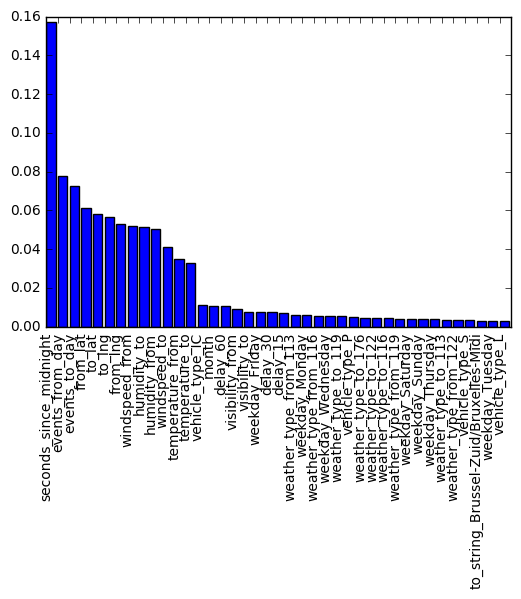

[[112  22  41]
 [ 42  44  33]
 [ 26  32  77]]
accuracy w/o FS: 0.543123543124
[[119  23  33]
 [ 41  43  35]
 [ 27  35  73]]
accuracy w/ 250 features: 0.547785547786
Fold 2 / 5


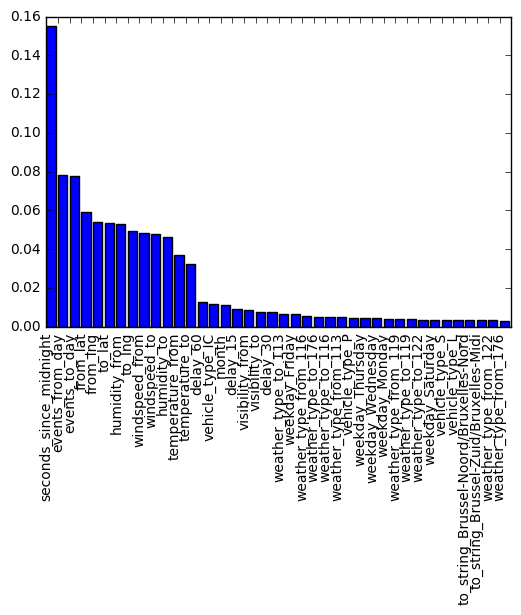

[[122  22  30]
 [ 34  46  39]
 [ 33  34  68]]
accuracy w/o FS: 0.551401869159
[[120  23  31]
 [ 34  47  38]
 [ 35  32  68]]
accuracy w/ 250 features: 0.549065420561
Fold 3 / 5


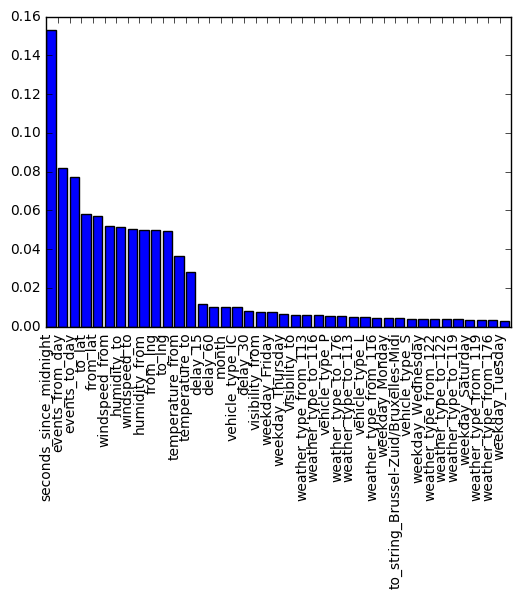

[[125  26  23]
 [ 40  42  37]
 [ 31  27  77]]
accuracy w/o FS: 0.570093457944
[[119  28  27]
 [ 39  42  38]
 [ 33  24  78]]
accuracy w/ 250 features: 0.558411214953
Fold 4 / 5


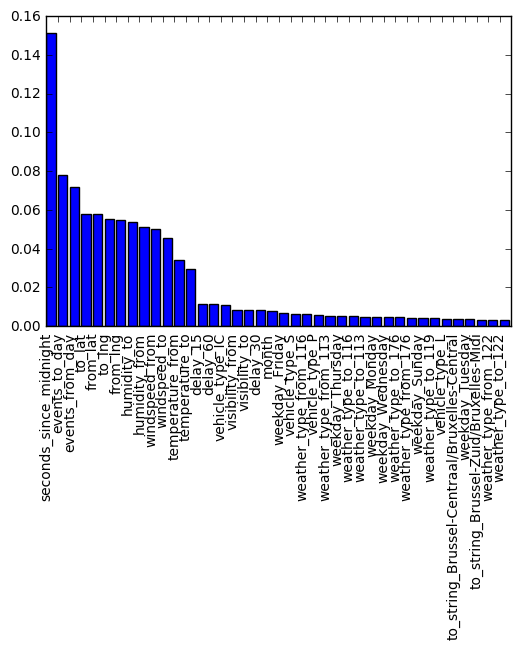

[[118  29  27]
 [ 45  37  37]
 [ 27  27  81]]
accuracy w/o FS: 0.551401869159
[[118  27  29]
 [ 47  37  35]
 [ 26  23  86]]
accuracy w/ 250 features: 0.56308411215
Fold 5 / 5


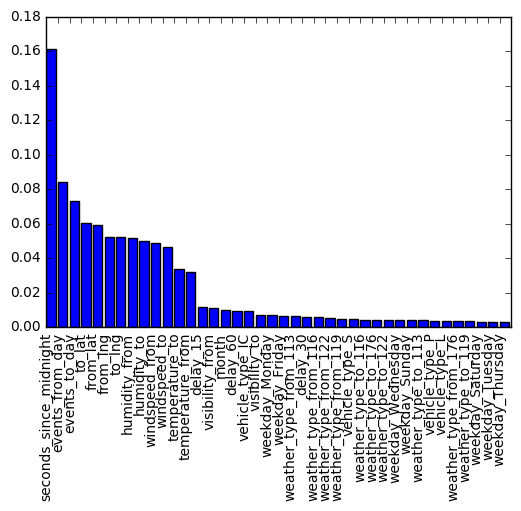

[[119  31  24]
 [ 40  52  26]
 [ 31  29  75]]
accuracy w/o FS: 0.576112412178
[[128  27  19]
 [ 41  50  27]
 [ 35  28  72]]
accuracy w/ 250 features: 0.585480093677


In [94]:
train_df = pd.read_csv('weather_delay_events_features.csv')
print(list(train_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = train_df['occupancy'].map(occupancy_mapping)
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])

#TODO: drop the duplicates!!!

NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.15, n_estimators=1500,
                         gamma=0.95, subsample=0.75, colsample_bytree=0.9,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.5,
                         min_child_weight=3.5, max_depth=13)
    xgb.fit(X_train, y_train)
    feature_importance_values = xgb.feature_importances_
    selected_features_idx = xgb.feature_importances_.argsort()[-PLOT_NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [feature_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/o FS:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    selected_features_idx = feature_importance_values.argsort()[-250:][::-1]
    X_train = train[[feature_df.columns[i] for i in selected_features_idx]]
    X_test = test[[feature_df.columns[i] for i in selected_features_idx]]
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/ 250 features:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1', 'seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'vehicle', 'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng', 'querytime', 'occupancy', 'temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 'delay_100', 'events_to_day', 'events_from_day']
Weather Features dataframe dimensions: 2140 x 552
Fold 1 / 5
(1711, 552) 1711
Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	

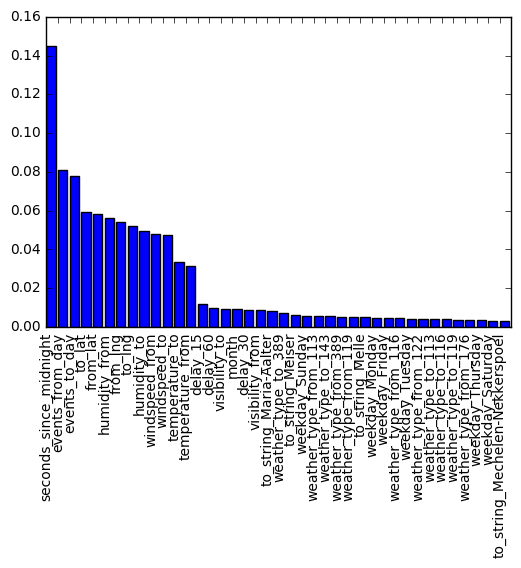

[[121  24  30]
 [ 33  45  41]
 [ 39  24  72]]
accuracy w/ Boruta FS: 0.554778554779
Fold 2 / 5
(1712, 552) 1712
Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	9 / 250
Confirmed: 	328
Tentative: 	224
Rejected: 	0
Iteration: 	10 / 250
Confirmed: 	328
Tentative: 	194
Rejected: 	30
Iteration: 	11 / 250
Confirmed: 	328
Tentative: 	194
Rejected: 	30
Iteration: 	12 / 250
Confirmed: 	328
Tentative: 	194
Rejected: 	30
Iteration: 	13 / 250
Confirmed: 	353
Tentative: 	169
Rejected: 	30
Iteration: 	14 / 250
Confirmed: 	353
Tentative: 	16

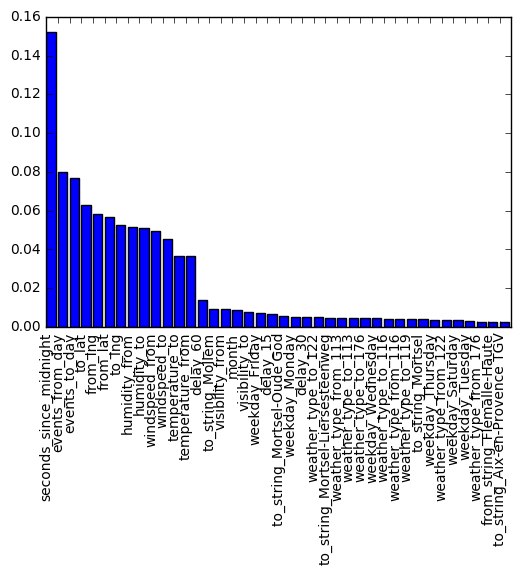

[[114  30  30]
 [ 38  39  42]
 [ 27  28  80]]
accuracy w/ Boruta FS: 0.544392523364
Fold 3 / 5
(1712, 552) 1712
Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	9 / 250
Confirmed: 	322
Tentative: 	230
Rejected: 	0
Iteration: 	10 / 250
Confirmed: 	322
Tentative: 	202
Rejected: 	28
Iteration: 	11 / 250
Confirmed: 	322
Tentative: 	202
Rejected: 	28
Iteration: 	12 / 250
Confirmed: 	322
Tentative: 	202
Rejected: 	28
Iteration: 	13 / 250
Confirmed: 	361
Tentative: 	163
Rejected: 	28
Iteration: 	14 / 250
Confirmed: 	361
Tentative: 	16

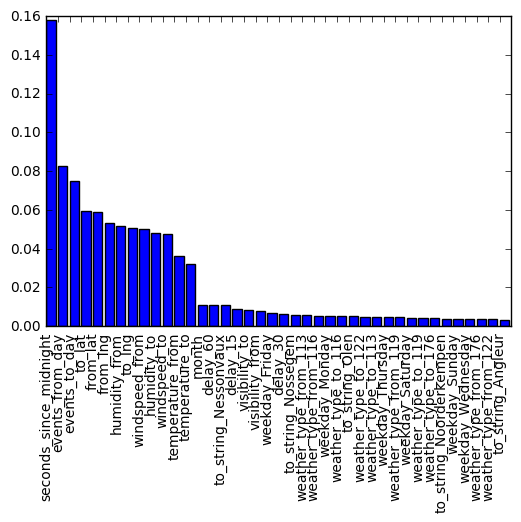

[[110  37  27]
 [ 31  58  30]
 [ 35  28  72]]
accuracy w/ Boruta FS: 0.560747663551
Fold 4 / 5
(1712, 552) 1712
Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	9 / 250
Confirmed: 	316
Tentative: 	186
Rejected: 	50
Iteration: 	10 / 250
Confirmed: 	316
Tentative: 	186
Rejected: 	50
Iteration: 	11 / 250
Confirmed: 	316
Tentative: 	186
Rejected: 	50
Iteration: 	12 / 250
Confirmed: 	316
Tentative: 	186
Rejected: 	50
Iteration: 	13 / 250
Confirmed: 	353
Tentative: 	149
Rejected: 	50
Iteration: 	14 / 250
Confirmed: 	353
Tentative: 	1

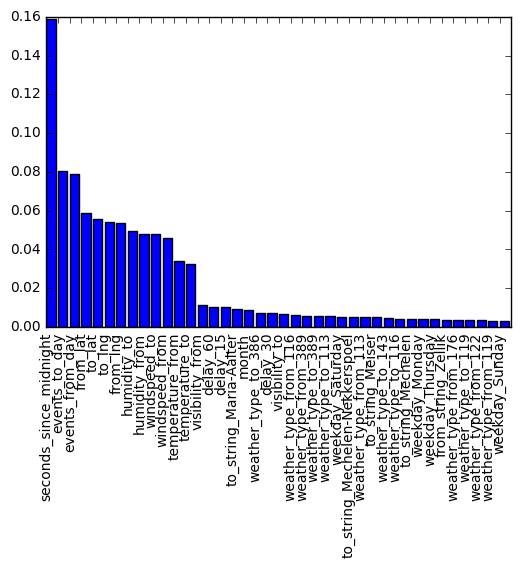

[[120  26  28]
 [ 35  52  32]
 [ 29  31  75]]
accuracy w/ Boruta FS: 0.577102803738
Fold 5 / 5
(1713, 552) 1713
Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	0
Tentative: 	552
Rejected: 	0
Iteration: 	9 / 250
Confirmed: 	323
Tentative: 	229
Rejected: 	0
Iteration: 	10 / 250
Confirmed: 	323
Tentative: 	187
Rejected: 	42
Iteration: 	11 / 250
Confirmed: 	323
Tentative: 	187
Rejected: 	42
Iteration: 	12 / 250
Confirmed: 	323
Tentative: 	187
Rejected: 	42
Iteration: 	13 / 250
Confirmed: 	356
Tentative: 	154
Rejected: 	42
Iteration: 	14 / 250
Confirmed: 	356
Tentative: 	15

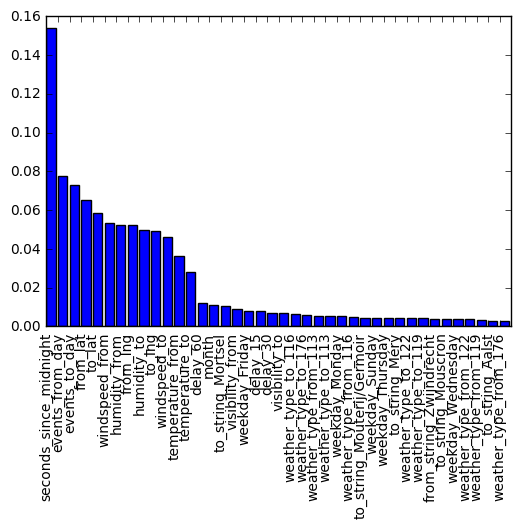

[[124  18  32]
 [ 52  40  26]
 [ 28  29  78]]
accuracy w/ Boruta FS: 0.566744730679


In [28]:
train_df = pd.read_csv('weather_delay_events_features.csv')
print(list(train_df.columns))
occupancy_mapping = {'low': 0, 'medium': 1, 'high': 2}
labels_df = train_df['occupancy'].map(occupancy_mapping)
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])
NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.15, n_estimators=1500,
                         gamma=0.95, subsample=0.75, colsample_bytree=0.9,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.5,
                         min_child_weight=3.5, max_depth=13)
    #xgb.fit(X_train, y_train)
    #feature_importance_values = xgb.feature_importances_
    #selected_features_idx = xgb.feature_importances_.argsort()[-PLOT_NR_FEATURES:][::-1]
    #plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    #plt.xticks(range(len(selected_features_idx)), [feature_df.columns[i] for i in selected_features_idx], rotation='vertical')
    #plt.show()

    #predictions = xgb.predict(X_test)
    #conf_matrix = confusion_matrix(y_test, predictions)
    #print(conf_matrix)
    #print('accuracy w/o FS:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
    rf = RandomForestClassifier(n_jobs=-1, class_weight='auto', max_depth=10)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, alpha=0.025, max_iter=250, perc=0.9999)
    print(X_train.as_matrix().shape, len(y_train.tolist()))
    feat_selector.fit(X_train.as_matrix(), y_train.tolist())
    
    # check selected features
    #select the chosen features from our dataframe.
    print(feat_selector.ranking_)
    X_train = X_train.ix[:,feat_selector.support_]
    X_test = X_test.ix[:,feat_selector.support_]
    
    xgb.fit(X_train, y_train)
    
    feature_importance_values = xgb.feature_importances_
    selected_features_idx = xgb.feature_importances_.argsort()[-PLOT_NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [feature_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()

    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy w/ Boruta FS:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

In [6]:
train_df = pd.read_csv('weather_delay_features.csv')
print(list(train_df.columns))
low_vs_all_labels_df = train_df['occupancy'].map({'medium': 1, 'high': 1, 'low': 0})
high_vs_all_labels_df = train_df['occupancy'].map({'medium': 0, 'high': 1, 'low': 0})
labels_df = train_df['occupancy'].map({'medium': 1, 'high': 2, 'low': 0})
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])
NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    low_y_train = low_vs_all_labels_df.iloc[train_idx].reset_index(drop=True)
    high_y_train = high_vs_all_labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.15, n_estimators=1500,
                         gamma=0.95, subsample=0.75, colsample_bytree=0.9,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.5,
                         min_child_weight=3.5, max_depth=13)
    
    xgb.fit(X_train, low_y_train)
    predictions_low = xgb.predict_proba(X_test)
    #hard_predictions_low = xgb.predict(X_test)
    #conf_matrix = confusion_matrix(y_test, hard_predictions_low)
    #print('low', conf_matrix)
    
    xgb.fit(X_train, high_y_train)
    predictions_high = xgb.predict_proba(X_test)
    #hard_predictions_high = xgb.predict(X_test)
    #conf_matrix = confusion_matrix(y_test, hard_predictions_high)
    #print('high', conf_matrix)
    
    xgb.fit(X_train, y_train)
    predictions = xgb.predict_proba(X_test)
    
    ensemble_predictions = []
    for prediction_low, prediction_high, prediction in zip(predictions_low, predictions_high, predictions):
        ensemble_prediction = [0.0,0.0,0.0]
        ensemble_prediction[0] += prediction_low[0]
        ensemble_prediction[1] += prediction_low[1]
        ensemble_prediction[2] += prediction_low[1]  # Index 1 contains {medium, high}
        ensemble_prediction[0] += prediction_high[0]
        ensemble_prediction[1] += prediction_high[0]  # Index 0 contains {low, medium}
        ensemble_prediction[2] += prediction_high[1]
        #ensemble_prediction = np.add(ensemble_prediction, prediction)
        ensemble_prediction = np.add(ensemble_prediction, prediction) # More weight for the 3-class classifier
        ensemble_prediction = [ensemble_prediction[x]/np.sum(ensemble_prediction) for x in range(len(ensemble_prediction))]
        ensemble_predictions.append(np.argmax(ensemble_prediction))
    
    conf_matrix = confusion_matrix(y_test, ensemble_predictions)
    print(conf_matrix)
    print('accuracy:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

['Unnamed: 0', 'Unnamed: 0.1', 'seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'vehicle', 'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng', 'querytime', 'occupancy', 'temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 'delay_100']
Weather Features dataframe dimensions: 2140 x 550
Fold 1 / 5
[[118  37  20]
 [ 37  49  33]
 [ 28  42  65]]
accuracy: 0.540792540793
Fold 2 / 5
[[116  39  19]
 [ 33  55  31]
 [ 24  36  75]]
accuracy: 0.57476635514
Fold 3 / 5
[[113  33  28]
 [ 38  47  34]
 [ 32  33  70]]
accuracy: 0.53738317757
Fold 4 / 5
[[111  36  27]
 [ 23  62  34]
 [ 30  34  71]]
accuracy: 0.570093457944
Fold 5 / 5
[[110  40  24]
 [ 26  66  26]
 [ 22  49  64]]
accuracy: 0.56206088993


In [68]:
train_df = pd.read_csv('weather_delay_features.csv')
print(list(train_df.columns))
labels_df = train_df['occupancy'].map({'medium': 0, 'high': 1, 'low': 0})
feature_df = train_df.drop(['occupancy', 'querytime', 'vehicle', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis=1)
feature_df = pd.get_dummies(feature_df, columns=['weather_type_from', 'weather_type_to', 'weekday', 
                                                 'from_string', 'to_string', 'vehicle_type'])
NR_FOLDS = 5
PLOT_NR_FEATURES = 40

print('Weather Features dataframe dimensions:', len(feature_df), 'x', len(feature_df.columns))
skf = StratifiedKFold(labels_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=None)

for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = feature_df.iloc[train_idx, :].reset_index(drop=True)
    y_train = labels_df.iloc[train_idx].reset_index(drop=True)
    train = X_train.copy()
    train[y_train.name] = y_train
    X_test = feature_df.iloc[test_idx, :].reset_index(drop=True)
    y_test = labels_df.iloc[test_idx].reset_index(drop=True)
    test = X_test.copy()
    test[y_test.name] = y_test
    
    #xgb = construct_classifier(train, X_train.columns, y_train.name)
    
    # These parameters were set after running construct_classifier for a certain number of folds and iterations
    xgb = XGBClassifier(learning_rate=0.15, n_estimators=1500,
                         gamma=0.95, subsample=0.75, colsample_bytree=0.9,
                         nthread=1, scale_pos_weight=1, reg_lambda=0.5,
                         min_child_weight=3.5, max_depth=13)
    svm_args={'class_weight': 'balanced'}
    svmsmote = SMOTE(ratio='auto', kind='svm', **svm_args)
    X_train_sampled, y_train_sampled = svmsmote.fit_sample(X_train, y_train)
    X_train_sampled = pd.DataFrame(X_train_sampled, columns=X_train.columns)
    y_train_sampled = pd.DataFrame(y_train_sampled, columns=[y_train.name])[y_train.name]
    
    xgb.fit(X_train_sampled, y_train_sampled)
    
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    print('accuracy medium-vs-all:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))

['Unnamed: 0', 'Unnamed: 0.1', 'seconds_since_midnight', 'weekday', 'from_string', 'to_string', 'vehicle_type', 'vehicle', 'month', 'from_lat', 'from_lng', 'to_lat', 'to_lng', 'querytime', 'occupancy', 'temperature_from', 'humidity_from', 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'humidity_to', 'windspeed_to', 'visibility_to', 'weather_type_to', 'delay_15', 'delay_30', 'delay_60', 'delay_100']


ValueError: labels ['Unnamed: 0.2'] not contained in axis

Features dataframe dimensions: 3031 x 123
Fold 1 / 5


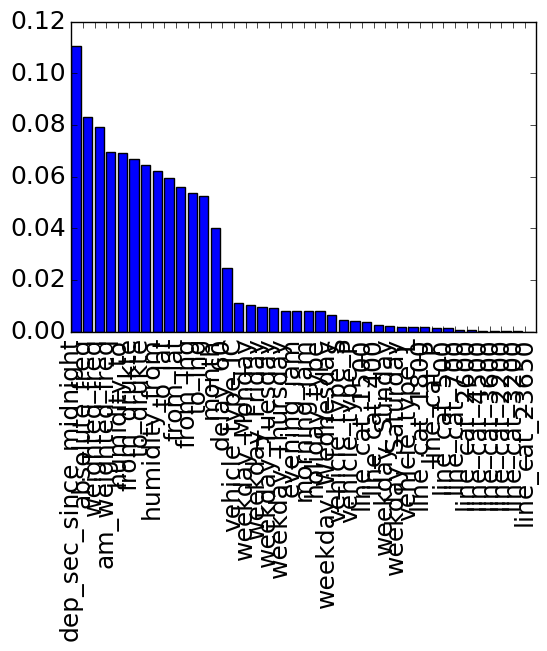

[[365  58]
 [106  78]]
accuracy: 0.72981878089
Fold 2 / 5


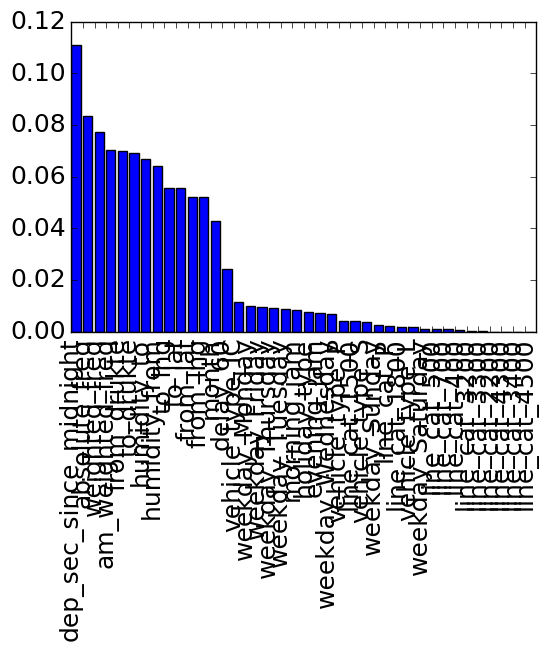

[[350  72]
 [108  76]]
accuracy: 0.70297029703
Fold 3 / 5


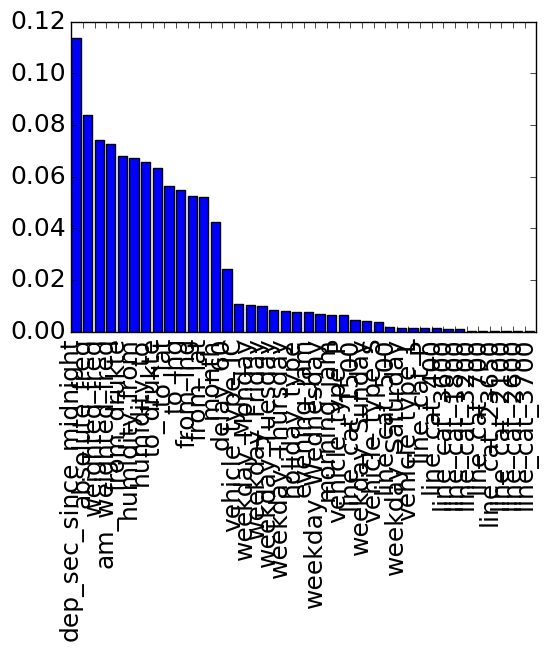

[[352  70]
 [102  82]]
accuracy: 0.716171617162
Fold 4 / 5


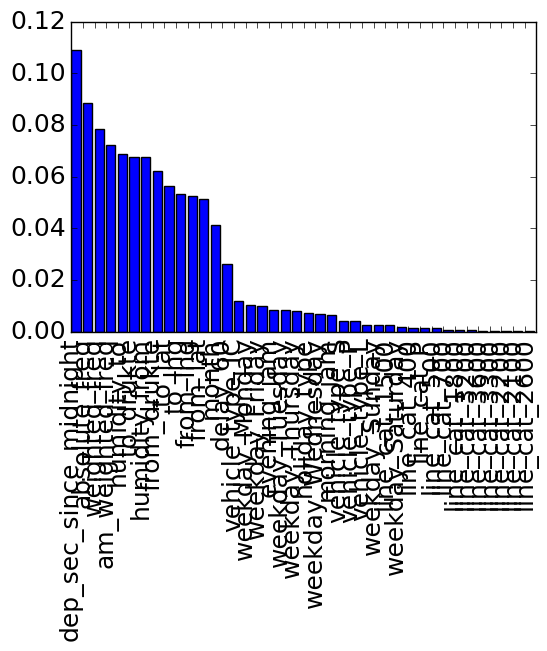

[[356  66]
 [109  75]]
accuracy: 0.711221122112
Fold 5 / 5


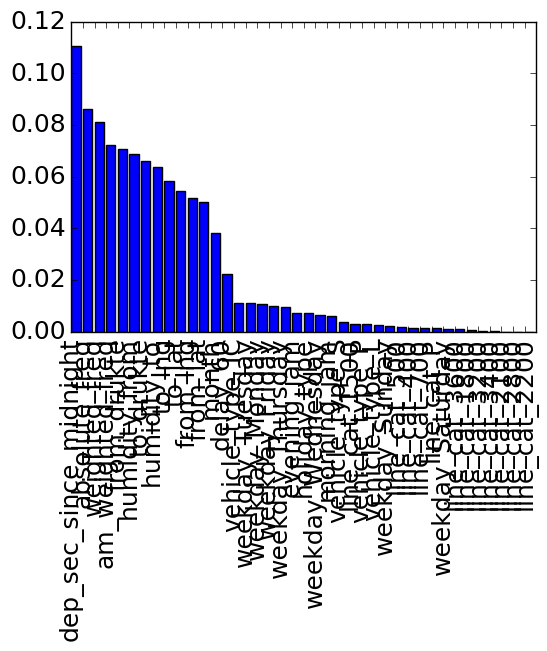

[[355  67]
 [111  73]]
accuracy: 0.706270627063
Average CLF accuracy 0.713290488851


In [11]:
# We want to predict if the train will be full when the user gets on
logs_df = pd.read_csv('logs.csv')
#logs_df = logs_df.sample(frac=0.75)

features_df = logs_df[['dep_sec_since_midnight', 'weekday', 'vehicle_type', 'month',
                       'from_lat', 'from_lng', 'to_lat', 'to_lng', 'evening_jam', 'morning_jam',
                       'humidity_from', 'humidity_to', 'delay_60', 'holiday_type', 
                       'from_drukte', 'to_drukte', 'absolute_freq', 'weighted_freq', 'am_weighted_freq',
                       'line_cat']]

# discarded features: 'drukte_absolute_freq', 'drukte_weighted_freq', 'drukte_am_weighted_freq',
# 'delay_15', 'delay_30', 'delay_100', , 'windspeed_to', 'visibility_to', 'weather_type_to'
# 'windspeed_from', 'visibility_from', 'weather_type_from', 'temperature_to', 'temperature_from'


features_df.to_csv('simple_features.csv')
features_df = pd.get_dummies(features_df, columns=['weekday', 'vehicle_type', 'line_cat'])
print('Features dataframe dimensions:', len(features_df), 'x', len(features_df.columns))
occupancy_mapping = {'low': 0, 'medium': 0, 'high': 1}
labels_clf_df = logs_df['clf_occupancy'].map(occupancy_mapping)
labels_reg_df = logs_df['reg_occupancy']

xgb = XGBClassifier(learning_rate=0.035, n_estimators=1000,
                     gamma=0.4, subsample=0.75, colsample_bytree=0.65,
                     nthread=1, scale_pos_weight=1, reg_lambda=0.5,
                     min_child_weight=9, max_depth=14)

NR_FOLDS = 5
NR_FEATURES = 40

skf = StratifiedKFold(labels_clf_df.values, n_folds=NR_FOLDS, shuffle=True, random_state=1337)

clf_accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf):
    print ('Fold', fold+1, '/', NR_FOLDS)
    X_train = features_df.iloc[train_idx, :].reset_index(drop=True)
    y_clf_train = labels_clf_df.iloc[train_idx].reset_index(drop=True)    
    y_reg_train = labels_reg_df.iloc[train_idx].reset_index(drop=True)
    X_test = features_df.iloc[test_idx, :].reset_index(drop=True)
    y_clf_test = labels_clf_df.iloc[test_idx].reset_index(drop=True)
    y_reg_test = labels_reg_df.iloc[test_idx].reset_index(drop=True)
    
    svm_args={'class_weight': 'balanced'}
    svmsmote = SMOTE(ratio='auto', kind='svm', **svm_args)
    X_train_sampled, y_train_sampled = svmsmote.fit_sample(X_train, y_clf_train)
    X_train_sampled = pd.DataFrame(X_train_sampled, columns=X_train.columns)
    y_train_sampled = pd.DataFrame(y_train_sampled, columns=[y_clf_train.name])[y_clf_train.name]
    train_sampled = X_train_sampled.copy()
    train_sampled[y_train_sampled.name] = y_train_sampled
    
    #xgb = construct_classifier(train_sampled, X_train_sampled.columns, y_train_sampled.name)
    
    xgb.fit(X_train_sampled, y_train_sampled)
    selected_features_idx = xgb.feature_importances_.argsort()[-NR_FEATURES:][::-1]
    plt.bar(range(len(selected_features_idx)), [xgb.feature_importances_[i] for i in selected_features_idx])
    plt.xticks(range(len(selected_features_idx)), [features_df.columns[i] for i in selected_features_idx], rotation='vertical')
    plt.show()
    
    predictions = xgb.predict(X_test)
    conf_matrix = confusion_matrix(y_clf_test, predictions)
    print(conf_matrix)
    acc = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix)
    print('accuracy:', acc)
    clf_accuracies.append(acc)
    
    #linreg.fit(X_train, y_reg_train)

    #predictions = linreg.predict(X_test)
    #pl.hist(predictions,normed=True)      #use this to draw histogram of your data
    #pl.show()  
    #clf_predictions = []
    #for prediction in predictions:
    #    if 2.8 < float(prediction) < 3.15:
    #        clf_predictions.append(1)
    #    elif float(prediction) <= 2.8:
    #        clf_predictions.append(0)
    #    else:
    #        clf_predictions.append(2)
    #conf_matrix = confusion_matrix(y_clf_test, clf_predictions)
    #print(conf_matrix)
    #print('Accuracy after regression:', sum([conf_matrix[i][i] for i in range(len(conf_matrix))])/np.sum(conf_matrix))
    
print('Average CLF accuracy', np.mean(clf_accuracies))